# init

In [1]:
%load_ext autoreload
%autoreload
import os
import sys
import pdb
import itertools
import _pickle as cPickle
import json
import argparse

import math
import random
from collections import OrderedDict, defaultdict, Counter
import re
import itertools
import multiprocessing

import nltk
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import tensorflow as tf
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from configure import get_config, update_config
from data_structure import get_batches, get_batches_iterator
from run import init, train, print_summary, print_sample, idxs_to_sents, get_text_from_sents, compute_topic_sents_probs,  compute_topic_posteriors_list, compute_logdetcovs
from evaluation.eval_utils import EvalMetrics
from evaluation.self_bleu import SelfBleu
from evaluate import get_evaluation_config, load_model, restore_model, evaluate_rouges, approx_rand_test, print_recursum
from evaluate import get_recursum_df, get_copycat_df, get_denoisesum_df, get_meansum_df, get_lead_df, get_lexrank_df, get_opinosis_df
from summarize import greedysum

from IPython.display import HTML

# plt.style.use('ggplot') 
plt.rcParams["font.family"] = "Times New Roman"
pd.options.display.precision = 2

pd.set_option('display.max_rows', 1000)
pd.options.display.precision = 4

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [3]:
def debug(variable, sample_batch=None):
    if sample_batch is None: sample_batch = test_batches[0]
    feed_dict = model.get_feed_dict(sample_batch, mode='eval', assertion=True)
    _variable = sess.run(variable, feed_dict=feed_dict)
    return _variable

def check(variable):
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    sample_batch = test_batches[0]
    feed_dict = model.get_feed_dict(sample_batch, mode='eval', assertion=True)
    _variable = sess.run(variable, feed_dict=feed_dict)
    return _variable

In [4]:
def add_bleu_df(data_df, system):
    text_list = data_df[system].to_list()
    for i in range(2, 6):
        data_df['bleu%i'%i] = SelfBleu(text_list, gram=i).get_bleu()
    return data_df

In [5]:
def load_sess(nb_name, n_path, nucleus=None):
    model = load_model(nb_name, train_batches, dev_batches, word_to_idx, bow_idxs, nucleus=nucleus, backup=False)
    ckpt = tf.train.get_checkpoint_state(model.config.dir_model)
    all_model_paths = ckpt.all_model_checkpoint_paths
    model_path = all_model_paths[n_path]
    sess = restore_model(model, model_path)
    return sess, model

# load data & config

In [6]:
config = get_evaluation_config('yelp')

In [7]:
np.random.seed(config.seed)
random.seed(config.seed)
eval_metrics = EvalMetrics()

In [8]:
train_df, dev_df, test_df, word_to_idx, idx_to_word, bow_idxs = cPickle.load(open(config.path_data, 'rb'))
train_batches = get_batches(train_df, config.batch_size)
dev_batches = get_batches(dev_df, config.batch_size)
test_batches = get_batches(test_df, config.batch_size)

In [9]:
config = update_config(config, train_batches, dev_batches, word_to_idx, bow_idxs)

In [10]:
train_df

,business_id,doc_l,sent_l,max_sent_l,bows,tfidfbows,token_idxs
0,--FBCX-N37CMYDfs790Bnw,40,"[12, 24, 7, 3, 20, 5, 9, 14, 21, 17, 26, 7, 19...",37,"(0, 279)\t1\n (0, 325)\t1\n (0, 1474)\t1\n...","(0, 279)\t5.2983866\n (0, 325)\t5.522667\n ...","[[20, 101, 149, 554, 9, 609, 1881, 5, 26, 49, ..."
1,--FBCX-N37CMYDfs790Bnw,45,"[5, 15, 12, 29, 4, 7, 4, 15, 10, 3, 9, 4, 5, 6...",29,"(1, 18)\t1\n (1, 114)\t1\n (1, 152)\t1\n ...","(1, 18)\t4.137313\n (1, 114)\t4.725527\n (...","[[27, 24, 7, 87, 73], [111, 15, 13, 133, 5, 19..."
2,--FBCX-N37CMYDfs790Bnw,38,"[8, 7, 14, 4, 7, 9, 18, 13, 18, 8, 5, 18, 7, 1...",31,"(0, 428)\t1\n (0, 817)\t1\n (1, 812)\t1\n ...","(0, 428)\t5.698207\n (0, 817)\t6.337675\n ...","[[12, 10, 8, 1164, 734, 15, 4, 96], [1210, 14,..."
3,--FBCX-N37CMYDfs790Bnw,38,"[4, 4, 22, 6, 31, 7, 9, 9, 7, 3, 5, 6, 6, 3, 7...",31,"(1, 2871)\t1\n (2, 5)\t1\n (2, 40)\t1\n (...","(1, 2871)\t7.8311386\n (2, 5)\t4.077216\n ...","[[20, 31, 36, 15727], [5, 20, 37, 3336], [379,..."
4,--FBCX-N37CMYDfs790Bnw,48,"[7, 5, 7, 9, 20, 4, 26, 12, 10, 6, 9, 12, 11, ...",36,"(0, 20)\t1\n (0, 52)\t1\n (2, 80)\t1\n (2...","(0, 20)\t4.1297684\n (0, 52)\t4.4676356\n ...","[[20, 75, 65, 199, 40, 13, 245], [4, 73, 11, 6..."
...,...,...,...,...,...,...,...
185491,zzwicjPC9g246MK2M1ZFBA,48,"[9, 5, 7, 6, 4, 12, 6, 4, 3, 4, 8, 5, 12, 10, ...",30,"(0, 99)\t1\n (0, 180)\t1\n (0, 683)\t1\n ...","(0, 99)\t4.6417527\n (0, 180)\t5.118548\n ...","[[13105, 11, 1015, 28, 13, 70, 427, 314, 185],..."
185492,zzwicjPC9g246MK2M1ZFBA,47,"[3, 9, 4, 6, 14, 5, 6, 7, 10, 8, 9, 30, 7, 21,...",32,"(1, 6)\t1\n (1, 2208)\t1\n (1, 2226)\t1\n ...","(1, 6)\t4.061798\n (1, 2208)\t7.5140276\n ...","[[13105, 11, 28], [3610, 161, 137, 23, 4, 2671..."
185493,zzwicjPC9g246MK2M1ZFBA,47,"[4, 13, 6, 9, 5, 7, 6, 5, 14, 4, 17, 5, 19, 31...",31,"(0, 2)\t1\n (1, 6)\t1\n (1, 44)\t1\n (1, ...","(0, 2)\t4.0370708\n (1, 6)\t4.061798\n (1,...","[[8, 36, 148, 96], [68, 447, 7, 8, 27, 161, 13..."
185494,zzwicjPC9g246MK2M1ZFBA,50,"[9, 4, 4, 8, 6, 3, 4, 3, 5, 15, 6, 5, 4, 12, 1...",32,"(0, 9)\t1\n (0, 13)\t1\n (0, 35)\t1\n (0,...","(0, 9)\t4.0703998\n (0, 13)\t4.162528\n (0...","[[1226, 168, 930, 222, 51, 2267, 182, 588, 179..."


In [14]:
train_df.business_id.value_counts()

jCR-xC4NqoEajjmstqX8sA    12
UkWme3kwg6L9rd4tCNB15w    12
3JnO3AEqRD8DbXkWP-gTFw    12
j0aiaJkrU-5VgbCsdx-txg    12
4cDWyZa6EqsY4XSWwLY7RA    12
                          ..
qMyYY8zpHusOXUd6wmqX2w     1
E7ZE01pv_RgeWEpM0SJ8AQ     1
Xk9vQupA97SSEvkB16otRg     1
LWvrTFkCSLPGldJqccGHhQ     1
O4kYogia0fbF85pCX10XiA     1
Name: business_id, Length: 15353, dtype: int64

## tmp

In [44]:
instance = test_df[test_df.summary.apply(lambda tx: 'let down' in tx)]

In [45]:
test_df[test_df.summary.apply(lambda tx: 'let down' in tx)]

,business_id,doc_l,sent_l,max_sent_l,bows,tfidfbows,token_idxs,text,summary,summary_tokens,summary_doc_l,summary_max_sent_l
64,1rebduwtmrHQhl32djRS7A,30,"[5, 12, 3, 7, 26, 17, 14, 6, 7, 8, 13, 17, 7, ...",32,"(0, 108)\t1\n (0, 1319)\t1\n (1, 42)\t1\n ...","(0, 108)\t4.6889486\n (0, 1319)\t7.158731\n...","[[4, 1710, 327, 11, 87], [4, 229, 10, 283, 23,...",The sesame bread is amazing. The sandwich was ...,"The food here is fantastic, easily the best su...","[[the, food, here, is, fantastic, ,, easily, t...",4,26


In [11]:
for txt in instance.text.values[0].split('</DOC>'):
    print(txt)
    print('---')

The sesame bread is amazing. The sandwich was huge but I ended up eating the whole thing. Very very good! 
---
  Delicious. Cheap. Friendly. Quick (if you want it to be!). What more could you ask for? 
The atmosphere at McGurkee's is reminiscent of an old town go-to with the friendliest staff in the valley. The sandwiches are inexpensive and are, in my opinion, the best Italian subs in AZ. Get the Sicilian if you want to know what a real sub tastes like.

Overall, go to McGurkee's. It'd be impossible to leave disappointed.  
---
 Been going here since the late 80s. A family run establishment, creating some of the best sandwiches in Phoenix.

From the toasted sesame rolls to the pickles and peppers, it's all about the details. My personal favorite is the Super Sicilian. Incredible!

Notable: The offer beer 
---
 just fell into this place today and WOW what a gem  GREAT sandwiches  I had the super sicilian and it was fantastic!  great meats  great toasted bread  great cheese and great dr

In [12]:
instance.summary.values[0]

'The food here is fantastic, easily the best sub sandwiches in the Arizona area. The staff are extremely friendly and will always go above and beyond in creating a delicious sandwich for you. The shop is local and family run, so I definitely choose it over a lot of the large national chains that are all around town. You will not be let down by the great food that they make here!'

# evaluate rouge

In [10]:
nb_name_list = [
    '2 yelp atttglm -tree 44 -sent -disc -turn -mean -prior -drnn -linear 40000 -lr 0.001 -lr_disc 0.00005',
#     '6 yelp atttglm -tree 44 -sent -disc -turn -mean -prior -drnn -linear 40000 -lr 0.001 -lr_disc 0.00005 -re30',
#     '1 yelp atttglm -tree 44 -sent -disc -turn -mean -prior -drnn -linear 40000 -lr 0.001 -lr_disc 0.00005 -re17',
#     '2 yelp atttglm -tree 44 -sent -disc -turn -mean -prior -drnn -linear 40000 -lr 0.001 -lr_disc 0.00005 -re2',
               ]
# n_path_list = [-1, -2, -2, -1]
n_path_list = [-2]
topk_list = [4]
threshold_list = [0.6, 0.7, 0.8]
truncate_list = [4, 5]
max_summary_l = 7
nb_name_list

['2 yelp atttglm -tree 44 -sent -disc -turn -mean -prior -drnn -linear 40000 -lr 0.001 -lr_disc 0.00005']

## treesum

In [11]:
%%time
rouges_tree_test_df = evaluate_rouges(test_batches=test_batches, train_batches=train_batches, dev_batches=dev_batches, word_to_idx=word_to_idx, bow_idxs=bow_idxs, \
                                              sys_sum=treesum, nb_name_list=nb_name_list, n_path_list=n_path_list, topk_list=topk_list, threshold_list=threshold_list, \
                                              truncate_list=truncate_list, max_summary_l=max_summary_l, num_split=50)

loading... 2 yelp atttglm -tree 44 -sent -disc -turn -mean -prior -drnn -linear 40000 -lr 0.001 -lr_disc 0.00005





The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing i

/home/isonuma/.pyenv/versions/anaconda3-5.3.1/envs/py36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/isonuma/.pyenv/versions/anaconda3-5.3.1/envs/py36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "




INFO:tensorflow:Restoring parameters from model/yelp/atttglm/atttglm-tree44-sent-disc-turn-mean-prior-drnn-linear40000-lr0.001-lr_disc0.00005/model-24000
CPU times: user 1min 44s, sys: 28.4 s, total: 2min 12s
Wall time: 3min 3s


In [12]:
rouges_tree_test_df

,nb_name,n_path,top_k,threshold,truncate,summary_l,rouge1,rouge2,rougeL
0,2 yelp atttglm -tree 44 -sent -disc -turn -mea...,-2,4,0.6,4,1,0.1204,0.0159,0.0971
1,2 yelp atttglm -tree 44 -sent -disc -turn -mea...,-2,4,0.6,4,2,0.1933,0.0318,0.1385
2,2 yelp atttglm -tree 44 -sent -disc -turn -mea...,-2,4,0.6,4,3,0.2332,0.0402,0.1567
3,2 yelp atttglm -tree 44 -sent -disc -turn -mea...,-2,4,0.6,4,4,0.2621,0.0467,0.1673
4,2 yelp atttglm -tree 44 -sent -disc -turn -mea...,-2,4,0.6,4,5,0.2761,0.0484,0.1694
5,2 yelp atttglm -tree 44 -sent -disc -turn -mea...,-2,4,0.6,4,6,0.2831,0.0499,0.1722
6,2 yelp atttglm -tree 44 -sent -disc -turn -mea...,-2,4,0.6,4,7,0.2867,0.0503,0.1731
7,2 yelp atttglm -tree 44 -sent -disc -turn -mea...,-2,4,0.6,5,1,0.1204,0.0159,0.0971
8,2 yelp atttglm -tree 44 -sent -disc -turn -mea...,-2,4,0.6,5,2,0.1887,0.0306,0.1374
9,2 yelp atttglm -tree 44 -sent -disc -turn -mea...,-2,4,0.6,5,3,0.2354,0.0406,0.1563


In [13]:
rouges_tree_test_df.loc[rouges_tree_test_df[['rouge1', 'rouge2', 'rougeL']].mean(axis=1).idxmax()]

nb_name      2 yelp atttglm -tree 44 -sent -disc -turn -mea...
n_path                                                      -2
top_k                                                        4
threshold                                                  0.8
truncate                                                     4
summary_l                                                    7
rouge1                                                  0.2868
rouge2                                                 0.05081
rougeL                                                  0.1726
Name: 34, dtype: object

## greedy sum

In [10]:
# %%time
# rouges_greedy_dev_df = evaluate_rouges(data_df=dev_df, train_batches=train_batches, dev_batches=dev_batches, word_to_idx=word_to_idx, bow_idxs=bow_idxs, \
#                                         sys_sum=greedysum, nb_name_list=nb_name_list, n_path_list=n_path_list, topk_list=topk_list, threshold_list=threshold_list, 
#                                         truncate_list=truncate_list, max_summary_l=max_summary_l, num_split=50)

In [16]:
%%time
rouges_greedy_test_df = evaluate_rouges(test_batches=test_batches, train_batches=train_batches, dev_batches=dev_batches, word_to_idx=word_to_idx, bow_idxs=bow_idxs, \
                                        sys_sum=greedysum, nb_name_list=nb_name_list, n_path_list=n_path_list, topk_list=topk_list, threshold_list=threshold_list, 
                                        truncate_list=truncate_list, max_summary_l=max_summary_l, num_split=50)

loading... 2 yelp atttglm -tree 44 -sent -disc -turn -mean -prior -drnn -linear 40000 -lr 0.001 -lr_disc 0.00005





The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing i

/home/isonuma/.pyenv/versions/anaconda3-5.3.1/envs/py36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/isonuma/.pyenv/versions/anaconda3-5.3.1/envs/py36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "




INFO:tensorflow:Restoring parameters from model/yelp/atttglm/atttglm-tree44-sent-disc-turn-mean-prior-drnn-linear40000-lr0.001-lr_disc0.00005/model-24000
CPU times: user 4min 4s, sys: 2min 3s, total: 6min 8s
Wall time: 20min 16s


In [21]:
filtered_greedy_test_df = rouges_greedy_test_df

In [22]:
filtered_greedy_test_df.loc[filtered_greedy_test_df[['rouge1', 'rouge2', 'rougeL']].mean(axis=1).idxmax()]

nb_name      2 yelp atttglm -tree 44 -sent -disc -turn -mea...
n_path                                                      -2
top_k                                                        8
threshold                                                  0.8
truncate                                                     4
summary_l                                                    7
rouge1                                                  0.3068
rouge2                                                 0.05552
rougeL                                                  0.1781
Name: 125, dtype: object

In [25]:
filtered_greedy_test_df.sort_values('rougeL', ascending=False)

,nb_name,n_path,top_k,threshold,truncate,summary_l,rouge1,rouge2,rougeL
125,2 yelp atttglm -tree 44 -sent -disc -turn -mea...,-2,8,0.8,4,7,0.3068,0.0555,0.1781
124,2 yelp atttglm -tree 44 -sent -disc -turn -mea...,-2,8,0.8,4,6,0.3011,0.0540,0.1769
131,2 yelp atttglm -tree 44 -sent -disc -turn -mea...,-2,8,0.8,5,6,0.2997,0.0523,0.1763
118,2 yelp atttglm -tree 44 -sent -disc -turn -mea...,-2,8,0.8,3,7,0.2983,0.0536,0.1762
90,2 yelp atttglm -tree 44 -sent -disc -turn -mea...,-2,8,0.6,4,7,0.3000,0.0545,0.1758
89,2 yelp atttglm -tree 44 -sent -disc -turn -mea...,-2,8,0.6,4,6,0.2970,0.0534,0.1757
132,2 yelp atttglm -tree 44 -sent -disc -turn -mea...,-2,8,0.8,5,7,0.3002,0.0517,0.1755
83,2 yelp atttglm -tree 44 -sent -disc -turn -mea...,-2,8,0.6,3,7,0.2931,0.0539,0.1746
138,2 yelp atttglm -tree 44 -sent -disc -turn -mea...,-2,8,0.8,6,6,0.2925,0.0468,0.1743
130,2 yelp atttglm -tree 44 -sent -disc -turn -mea...,-2,8,0.8,5,5,0.2931,0.0521,0.1739


# comparison of rouges

## recursum

In [10]:
# nb_name = '7 yelp atttglm -tree 66 -sent -disc -turn -mean -prior -drnn -linear 40000 -lr 0.0005 -lr_disc 0.00005 -nucleus 0.4 -r1'
# n_path = -7
nb_name = '3 yelp atttglm -tree 44 -sent -disc -turn -mean -prior -drnn -linear 40000 -lr 0.0005 -lr_disc 0.00005 -nucleus 0.25 -r1'
n_path = -1
# nb_name = '0 yelp atttglm -tree 44 -sent -disc -turn -mean -prior -drnn -linear 40000 -lr 0.0005 -lr_disc 0.00005 -nucleus 0.95'
# n_path = -3
# nb_name = '3 yelp atttglm -tree 44 -sent -disc -turn -mean -prior -drnn -linear 40000 -lr 0.0005 -lr_disc 0.00005 -nucleus 0.25'
# n_path = -3
# nb_name = '7 yelp atttglm -tree 66 -sent -disc -turn -mean -prior -drnn -linear 40000 -lr 0.0005 -lr_disc 0.00005 -nucleus 0.4 -r1'
# n_path = -1

model = load_model(nb_name, train_batches, dev_batches, word_to_idx, bow_idxs, nucleus=0.4)
ckpt = tf.train.get_checkpoint_state(model.config.dir_model)
all_model_paths = ckpt.all_model_checkpoint_paths
model_path = all_model_paths[n_path]
sess = restore_model(model, model_path)






The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of pass

In [12]:
%%time
# nb_name = '3 yelp atttglm -tree 44 -sent -disc -turn -mean -prior -drnn -linear 40000 -lr 0.0005 -lr_disc 0.00005 -nucleus 0.25'
# n_path = -3
recursum_df = get_recursum_df(sess, model, test_df, sys_sum=greedysum, topk=8, threshold=0.6, truncate=0, summary_l=6, num_split=50)
recursum_df.to_pickle(model.config.path_recursum_df%n_path)
recursum_df = pd.read_pickle(model.config.path_recursum_df%n_path)
recursum_df[['rouge1', 'rouge2', 'rougeL']].mean()

CPU times: user 7.55 s, sys: 9.01 s, total: 16.6 s
Wall time: 1min 21s


rouge1    0.3216
rouge2    0.0506
rougeL    0.1742
dtype: float64

In [24]:
%%time
# nb_name = '7 yelp atttglm -tree 66 -sent -disc -turn -mean -prior -drnn -linear 40000 -lr 0.0005 -lr_disc 0.00005 -nucleus 0.4 -r1'
# n_path = -1
recursum_df = get_recursum_df(sess, model, test_df, sys_sum=greedysum, topk=8, threshold=0.6, truncate=0, summary_l=6, num_split=50)
recursum_df.to_pickle(model.config.path_recursum_df%n_path)
recursum_df = pd.read_pickle(model.config.path_recursum_df%n_path)
recursum_df[['rouge1', 'rouge2', 'rougeL']].mean()

CPU times: user 10.3 s, sys: 7.47 s, total: 17.8 s
Wall time: 7min 19s


rouge1    0.3228
rouge2    0.0470
rougeL    0.1734
dtype: float64

In [11]:
%%time
# nb_name = '3 yelp atttglm -tree 44 -sent -disc -turn -mean -prior -drnn -linear 40000 -lr 0.0005 -lr_disc 0.00005 -nucleus 0.25 -r1'
# n_path = -1
recursum_df = get_recursum_df(sess, model, test_df, sys_sum=greedysum, topk=8, threshold=0.6, truncate=0, summary_l=6, num_split=50)
recursum_df.to_pickle(model.config.path_recursum_df%n_path)
recursum_df = pd.read_pickle(model.config.path_recursum_df%n_path)
recursum_df[['rouge1', 'rouge2', 'rougeL']].mean()

CPU times: user 7.32 s, sys: 5.39 s, total: 12.7 s
Wall time: 3min 35s


rouge1    0.3257
rouge2    0.0480
rougeL    0.1774
dtype: float64

In [25]:
recursum_df.recursum.iloc[33]

"I would definitely recommend this place. My wife and I have been to a few years. They are always great. The other time I've been to the salon and I will definitely be back. The staff is very friendly and welcoming. Great place to go."

## lead

In [26]:
lead_df = get_lead_df(test_df, config)
lead_df[['rouge1', 'rouge2', 'rougeL']].mean()

FileNotFoundError: [Errno 2] No such file or directory: 'eval/yelp/lead_df.pkl'

## opinosis

In [14]:
opinosis_df = get_opinosis_df(test_df, dev_df, config)
opinosis_df[['rouge1', 'rouge2', 'rougeL']].mean()

rouge1    0.2580
rouge2    0.0292
rougeL    0.1457
dtype: float64

## lexrank

In [10]:
lexrank_df = get_lexrank_df(test_df, n_sents=6, min_sent_l=0, config=config)
lexrank_df[['rouge1', 'rouge2', 'rougeL']].mean()

/home/isonuma/atttglm/evaluate.py:271: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  get_text_from_sents(idxs_to_sents(np.array(row.token_idxs)[row.summary_indices], config)), 1)


rouge1    0.2640
rouge2    0.0319
rougeL    0.1435
dtype: float64

## meansum

In [14]:
meansum_df = get_meansum_df(config)
meansum_df[['rouge1', 'rouge2', 'rougeL']].mean()

rouge1    0.2866
rouge2    0.0373
rougeL    0.1577
dtype: float64

## copycat

In [15]:
copycat_df = get_copycat_df(test_df, config)
copycat_df[['rouge1', 'rouge2', 'rougeL']].mean()

rouge1    0.2895
rouge2    0.0480
rougeL    0.1776
dtype: float64

## denoisesum

In [16]:
denoisesum_df = get_denoisesum_df(config)
denoisesum_df[['rouge1', 'rouge2', 'rougeL']].mean()

rouge1    0.2977
rouge2    0.0502
rougeL    0.1763
dtype: float64

## pegasus

In [14]:
pegasus_df = get_pegasus_df(config)
pegasus_df[['rouge1', 'rouge2', 'rougeL']].mean()

rouge1    0.3203
rouge2    0.0564
rougeL    0.1808
dtype: float64

In [15]:
print('&'.join(['%.2f'%v for v in pegasus_df[['rouge1', 'rouge2', 'rougeL']].mean().values*100]))

32.03&5.64&18.08


## results

In [19]:
indices = ['Lead', 'LexRank', 'Opinosis', 'MeanSum', 'Copycat', 'DenoiseSum', 'RecurSum']
data_dfs = [lead_df, lexrank_df, opinosis_df, meansum_df, copycat_df, denoisesum_df, recursum_df]
assert len(indices) == len(data_dfs)

In [20]:
results_df = pd.DataFrame.from_dict({index: data_df[['rouge1', 'rouge2', 'rougeL']].mean() for index, data_df in zip(indices, data_dfs)}, orient='index')
results_df

,rouge1,rouge2,rougeL
Lead,0.2742,0.0374,0.1434
LexRank,0.2653,0.0330,0.1454
Opinosis,0.2580,0.0292,0.1457
MeanSum,0.2866,0.0373,0.1577
Copycat,0.2895,0.0480,0.1776
DenoiseSum,0.2977,0.0502,0.1763
RecurSum,0.3324,0.0515,0.1801


In [21]:
systems = ['recursum', 'copycat', 'meansum', 'denoisesum', 'lexrank']
data_dfs = [recursum_df, copycat_df, meansum_df, denoisesum_df, lexrank_df]
assert len(systems) == len(data_dfs)

for system, data_df in zip(systems, data_dfs):
    text_list = data_df[system].to_list()
    data_df['bleu2'] = SelfBleu(text_list, gram=2).get_bleu()
    data_df['bleu3'] = SelfBleu(text_list, gram=3).get_bleu()
    data_df['bleu4'] = SelfBleu(text_list, gram=4).get_bleu()
    data_df['bleu5'] = SelfBleu(text_list, gram=5).get_bleu()
    print(system, data_df[['bleu2', 'bleu3', 'bleu4', 'bleu5']].mean())

recursum bleu2    0.8049
bleu3    0.6430
bleu4    0.4837
bleu5    0.3466
dtype: float64
copycat bleu2    0.8145
bleu3    0.7299
bleu4    0.6397
bleu5    0.5483
dtype: float64
meansum bleu2    0.6684
bleu3    0.4740
bleu4    0.3070
bleu5    0.1867
dtype: float64
denoisesum bleu2    0.8412
bleu3    0.7139
bleu4    0.5804
bleu5    0.4525
dtype: float64
lexrank bleu2    0.4456
bleu3    0.1976
bleu4    0.0799
bleu5    0.0384
dtype: float64


# model variants

In [29]:
# nb_name = '2 yelp atttglm -tree 44 -sent -mean -prior -drnn -linear 40000 -lr 0.0005 -lr_disc 0.00005 -nucleus 0.5 -step 40000 -r2'
# n_path=-1
# ckpt = tf.train.get_checkpoint_state(model.config.dir_model)
# all_model_paths = ckpt.all_model_checkpoint_paths
# model_path = all_model_paths[n_path]
# sess = restore_model(model, model_path)
# recursum_nondisc_df = get_recursum_df(sess, model, test_df, sys_sum=greedysum, topk=8, threshold=0.6, truncate=0, summary_l=6, num_split=50)
# recursum_nondisc_df = add_bleu_df(recursum_nondisc_df, system='recursum')
# recursum_nondisc_df.to_pickle(config.path_recursum_nondisc)
recursum_nondisc_df = pd.read_pickle(config.path_recursum_nondisc)
print(recursum_nondisc_df[['rouge1', 'rouge2', 'rougeL']].mean())
print(recursum_nondisc_df[['bleu2', 'bleu3', 'bleu4', 'bleu5']].mean())

rouge1    0.3052
rouge2    0.0350
rougeL    0.1643
dtype: float64
bleu2    0.7822
bleu3    0.5418
bleu4    0.3042
bleu5    0.1353
dtype: float64


In [24]:
# nb_name = '4 yelp atttglm -tree 44 -nonatt -sent -disc -turn -mean -prior -drnn -linear 40000 -lr 0.0005 -lr_disc 0.00005 -nucleus 0.5 -step 40000 -r0'
# n_path=-1
# model = load_model(nb_name, train_batches, dev_batches, word_to_idx, bow_idxs, nucleus=None, backup=False)
# ckpt = tf.train.get_checkpoint_state(model.config.dir_model)
# all_model_paths = ckpt.all_model_checkpoint_paths
# model_path = all_model_paths[n_path]
# sess = restore_model(model, model_path)
# recursum_nonatt_df = get_recursum_df(sess, model, test_df, sys_sum=greedysum, topk=8, threshold=0.6, truncate=0, summary_l=6, num_split=50)
# recursum_nonatt_df = add_bleu_df(recursum_nonatt_df, system='recursum')
# recursum_nonatt_df.to_pickle(config.path_recursum_nonatt)
recursum_nonatt_df = pd.read_pickle(config.path_recursum_nonatt)
print(recursum_nonatt_df[['rouge1', 'rouge2', 'rougeL']].mean())
print(recursum_nonatt_df[['bleu2', 'bleu3', 'bleu4', 'bleu5']].mean())

rouge1    0.3062
rouge2    0.0487
rougeL    0.1701
dtype: float64
bleu2    0.8084
bleu3    0.6611
bleu4    0.5089
bleu5    0.3702
dtype: float64


In [13]:
# sess, model = load_sess(nb_name = '2 yelp atttglm -tree 44 -sent -disc -turn -mean -prior -drnn -linear 40000 -lr 0.001 -lr_disc 0.00005', n_path=-2, nucleus=1)
# recursum_nonnucleus_df = get_recursum_df(sess, model, test_df, sys_sum=greedysum, topk=8, threshold=0.6, truncate=0, summary_l=6, num_split=50)
# recursum_nonnucleus_df = add_bleu_df(recursum_nonnucleus_df, system='recursum')
# recursum_nonnucleus_df.to_pickle(config.path_recursum_nonnucleus)

# number of topics

In [41]:
nb_name = '3 yelp atttglm -tree 44 -sent -disc -turn -mean -prior -drnn -linear 40000 -lr 0.0005 -lr_disc 0.00005 -nucleus 0.25'
n_path = -1
recursum_df = pd.read_pickle(get_config(nb_name).path_recursum_df%n_path)
recursum_df = add_bleu_df(recursum_df, system='recursum')
print(recursum_df[['rouge1', 'rouge2', 'rougeL']].mean())
print(recursum_df[['bleu2', 'bleu3', 'bleu4', 'bleu5']].mean())

rouge1    0.3324
rouge2    0.0515
rougeL    0.1801
dtype: float64
bleu2    0.8049
bleu3    0.6430
bleu4    0.4837
bleu5    0.3466
dtype: float64


In [11]:
# sess, model = load_sess(nb_name = '7 yelp atttglm -tree 66 -sent -disc -turn -mean -prior -drnn -linear 40000 -lr 0.0005 -lr_disc 0.00005 -nucleus 0.4 -r1', n_path=-1)
# recursum_66_df = get_recursum_df(sess, model, test_df, sys_sum=greedysum, topk=8, threshold=0.6, truncate=0, summary_l=6, num_split=50)
# recursum_66_df = add_bleu_df(recursum_66_df, system='recursum')
# recursum_66_df.to_pickle(config.path_recursum_66)
recursum_66_df = pd.read_pickle(config.path_recursum_66)
print(recursum_66_df[['rouge1', 'rouge2', 'rougeL']].mean())
print(recursum_66_df[['bleu2', 'bleu3', 'bleu4', 'bleu5']].mean())

rouge1    0.3325
rouge2    0.0482
rougeL    0.1781
dtype: float64
bleu2    0.8555
bleu3    0.7454
bleu4    0.6283
bleu5    0.5158
dtype: float64


In [12]:
# sess, model = load_sess(nb_name = '4 yelp atttglm -tree 55 -sent -disc -turn -mean -prior -drnn -linear 40000 -lr 0.0005 -lr_disc 0.00005 -nucleus 0.4 -r0', n_path=-5)
# recursum_55_df = get_recursum_df(sess, model, test_df, sys_sum=greedysum, topk=8, threshold=0.6, truncate=0, summary_l=6, num_split=50)
# recursum_55_df = add_bleu_df(recursum_55_df, system='recursum')
# recursum_55_df.to_pickle(config.path_recursum_55)
recursum_55_df = pd.read_pickle(config.path_recursum_55)
print(recursum_55_df[['rouge1', 'rouge2', 'rougeL']].mean())
print(recursum_55_df[['bleu2', 'bleu3', 'bleu4', 'bleu5']].mean())

rouge1    0.3194
rouge2    0.0478
rougeL    0.1750
dtype: float64
bleu2    0.8467
bleu3    0.7156
bleu4    0.5727
bleu5    0.4373
dtype: float64


In [13]:
# sess, model = load_sess(nb_name = '3 yelp atttglm -tree 44 -sent -disc -turn -mean -prior -drnn -linear 40000 -lr 0.0005 -lr_disc 0.00005 -nucleus 0.25', n_path=-3)
# recursum_44_df = get_recursum_df(sess, model, test_df, sys_sum=greedysum, topk=8, threshold=0.6, truncate=0, summary_l=6, num_split=50)
# recursum_44_df = add_bleu_df(recursum_44_df, system='recursum')
# recursum_44_df.to_pickle(config.path_recursum_44)
recursum_44_df = pd.read_pickle(config.path_recursum_44)
print(recursum_44_df[['rouge1', 'rouge2', 'rougeL']].mean())
print(recursum_44_df[['bleu2', 'bleu3', 'bleu4', 'bleu5']].mean())

rouge1    0.3216
rouge2    0.0506
rougeL    0.1742
dtype: float64
bleu2    0.8513
bleu3    0.7370
bleu4    0.6132
bleu5    0.4957
dtype: float64


In [14]:
# sess, model = load_sess(nb_name = '2 yelp atttglm -tree 33 -sent -disc -turn -mean -prior -drnn -linear 40000 -lr 0.0005 -lr_disc 0.00005 -nucleus 0.4 -r0', n_path=-1)
# recursum_33_df = get_recursum_df(sess, model, test_df, sys_sum=greedysum, topk=8, threshold=0.6, truncate=0, summary_l=6, num_split=50)
# recursum_33_df = add_bleu_df(recursum_33_df, system='recursum')
# recursum_33_df.to_pickle(config.path_recursum_33)
recursum_33_df = pd.read_pickle(config.path_recursum_33)
print(recursum_33_df[['rouge1', 'rouge2', 'rougeL']].mean())
print(recursum_33_df[['bleu2', 'bleu3', 'bleu4', 'bleu5']].mean())

rouge1    0.3142
rouge2    0.0443
rougeL    0.1719
dtype: float64
bleu2    0.8292
bleu3    0.6965
bleu4    0.5613
bleu5    0.4346
dtype: float64


In [15]:
# sess, model = load_sess(nb_name = '0 yelp atttglm -tree 22 -sent -disc -turn -mean -prior -drnn -linear 40000 -lr 0.0005 -lr_disc 0.00005 -nucleus 0.4 -r0', n_path=-1)
# recursum_22_df = get_recursum_df(sess, model, test_df, sys_sum=greedysum, topk=8, threshold=0.6, truncate=0, summary_l=6, num_split=50)
# recursum_22_df = add_bleu_df(recursum_22_df, system='recursum')
# recursum_22_df.to_pickle(config.path_recursum_22)
recursum_22_df = pd.read_pickle(config.path_recursum_22)
print(recursum_22_df[['rouge1', 'rouge2', 'rougeL']].mean())
print(recursum_22_df[['bleu2', 'bleu3', 'bleu4', 'bleu5']].mean())

rouge1    0.2903
rouge2    0.0439
rougeL    0.1694
dtype: float64
bleu2    0.8016
bleu3    0.6649
bleu4    0.5297
bleu5    0.4067
dtype: float64


In [17]:
sess, model = load_sess(nb_name = '0 yelp atttglm -tree 3 -sent -disc -turn -mean -prior -drnn -linear 40000 -lr 0.0005 -lr_disc 0.00005 -nucleus 0.5 -step 40000 -r0', n_path=-1)
recursum_3_df = get_recursum_df(sess, model, test_df, sys_sum=greedysum, topk=8, threshold=0.6, truncate=0, summary_l=6, num_split=50)
recursum_3_df = add_bleu_df(recursum_3_df, system='recursum')

/home/isonuma/.pyenv/versions/anaconda3-5.3.1/envs/py36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/isonuma/.pyenv/versions/anaconda3-5.3.1/envs/py36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Restoring parameters from model/yelp/atttglm/atttglm-tree3-sent-disc-turn-mean-prior-drnn-linear40000-lr0.0005-lr_disc0.00005-nucleus0.5-step40000-r0/model-39000


In [28]:
sess, model = load_sess(nb_name = '5 yelp atttglm -tree 333 -sent -disc -turn -mean -prior -drnn -linear 40000 -lr 0.0005 -lr_disc 0.00005 -nucleus 0.5 -step 40000 -r1', n_path=-1)
recursum_333_df = get_recursum_df(sess, model, test_df, sys_sum=greedysum, topk=8, threshold=0.6, truncate=0, summary_l=6, num_split=50)
recursum_333_df = add_bleu_df(recursum_333_df, system='recursum')

/home/isonuma/.pyenv/versions/anaconda3-5.3.1/envs/py36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/isonuma/.pyenv/versions/anaconda3-5.3.1/envs/py36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Restoring parameters from model/yelp/atttglm/atttglm-tree333-sent-disc-turn-mean-prior-drnn-linear40000-lr0.0005-lr_disc0.00005-nucleus0.5-step40000-r1/model-40500


In [39]:
# recursum_3_df.to_pickle(config.path_recursum_3)
recursum_3_df = pd.read_pickle(config.path_recursum_3)
print(recursum_3_df[['rouge1', 'rouge2', 'rougeL']].mean())
print(recursum_3_df[['bleu2', 'bleu3', 'bleu4', 'bleu5']].mean())

rouge1    0.2363
rouge2    0.0238
rougeL    0.1435
dtype: float64
bleu2    0.6247
bleu3    0.3926
bleu4    0.2076
bleu5    0.1034
dtype: float64


In [40]:
# recursum_333_df.to_pickle(config.path_recursum_333)
recursum_333_df = pd.read_pickle(config.path_recursum_333)
print(recursum_333_df[['rouge1', 'rouge2', 'rougeL']].mean())
print(recursum_333_df[['bleu2', 'bleu3', 'bleu4', 'bleu5']].mean())

rouge1    0.3255
rouge2    0.0475
rougeL    0.1770
dtype: float64
bleu2    0.8194
bleu3    0.6682
bleu4    0.5059
bleu5    0.3598
dtype: float64


In [35]:
pd.DataFrame({
    '1x3': recursum_3_df[['rouge1', 'rouge2', 'rougeL']].mean(),
    '1x3x3': recursum_33_df[['rouge1', 'rouge2', 'rougeL']].mean(),
    '(1x4x4)': recursum_df[['rouge1', 'rouge2', 'rougeL']].mean(),
    '1x3x3x3': recursum_333_df[['rouge1', 'rouge2', 'rougeL']].mean(),
}).T

,rouge1,rouge2,rougeL
1x3,0.2363,0.0238,0.1435
1x3x3,0.3142,0.0443,0.1719
(1x4x4),0.3324,0.0515,0.1801
1x3x3x3,0.3255,0.0475,0.1770


# compare summary

## comparison from review length

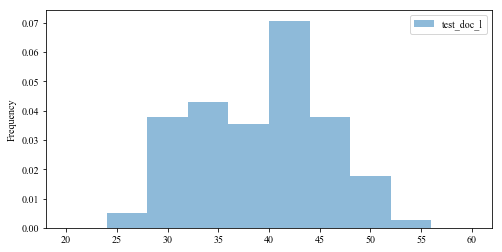

In [912]:
results_length_df = test_df.copy()
results_length_df.doc_l.plot(bins=10, alpha=0.5, figsize=(8,4), kind='hist', range=(20, 60), density=True, legend=True, label='test_doc_l');

In [913]:
def convert_range(doc_l, min_doc_l, max_doc_l, range_doc_l):
    range_l_list = [range(min_doc_l+i*range_doc_l, min_doc_l+(i+1)*range_doc_l) for i in range(int((max_doc_l-min_doc_l)/range_doc_l))]
    range_l_list[0] = range(0, range_l_list[0][-1]+1)
    range_l_list[-1] = range(range_l_list[-1][0], 1000)
    range_l = range_l_list[[doc_l in range_l for range_l in range_l_list].index(True)][0]
    return range_l

In [957]:
results_length_df['range_doc_l'] = results_length_df['doc_l'].apply(lambda doc_l: convert_range(doc_l, min_doc_l=25, max_doc_l=55, range_doc_l=10))
results_length_df['rougeL_recursum'] = recursum_df['rougeL']*100
results_length_df['rougeL_copycat'] = copycat_df['rougeL']*100
results_length_df['rougeL_meansum'] = meansum_df['rougeL']*100
mean_results_length_df = results_length_df[['range_doc_l', 'rougeL_meansum', 'rougeL_copycat', 'rougeL_recursum']].groupby('range_doc_l').mean()
mean_results_length_df

,rougeL_meansum,rougeL_copycat,rougeL_recursum
range_doc_l,,,
0,16.1170,18.3499,17.9229
35,15.3505,16.8780,18.4100
45,16.1964,18.8539,19.4601


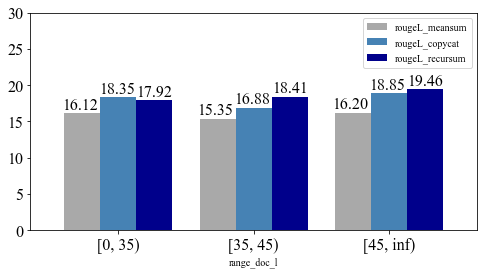

In [958]:
fontsize = 16
mean_results_length_df.plot(kind='bar',
                                                     color=['darkgray', 'steelblue', 'darkblue'],
                                                     yticks=[5*i for i in range(7)],
                                                     figsize=(8, 4),
                                                     fontsize=fontsize,
                                                     width=0.8
                                                    )
plt.xticks([0, 1, 2], ['[0, 35)', '[35, 45)', '[45, inf)'], rotation=0)

x_axes = [-0.15, 0.12, 0.40]
for i, values in enumerate(mean_results_length_df.values):
        for x_axis, val in zip(x_axes, values):
            plt.text(i+x_axis, val, '%.2f' % val, ha='right', va='bottom', fontsize=fontsize)

## print summary

In [16]:
# i=0
i=31
# i=7

In [17]:
doc_index = i
instance = recursum_df.iloc[doc_index]
reference_summary = recursum_df.summary.iloc[doc_index]
recursum_summary = recursum_df.recursum.iloc[doc_index]
# copycat_summary = copycat_df.copycat.iloc[doc_index]
# meansum_summary = meansum_df.meansum.iloc[doc_index]
# lexrank_summary = lexrank_df.lexrank.iloc[doc_index]

print(doc_index)
print('------------Reference------------')
print(reference_summary)
# print('------------Copycat------------')
# print(' '.join(['%s:%.3f' % (k, v) for k, v in copycat_df[['rouge1', 'rouge2', 'rougeL']].iloc[doc_index].to_dict().items()]))
# print(copycat_summary)
# print('------------MeanSum------------')
# print(' '.join(['%s:%.3f' % (k, v) for k, v in meansum_df[['rouge1', 'rouge2', 'rougeL']].iloc[doc_index].to_dict().items()]))
# print(meansum_summary)
# print('------------Lexrank------------')
# print(' '.join(['%s:%.3f' % (k, v) for k, v in lexrank_df[['rouge1', 'rouge2', 'rougeL']].iloc[doc_index].to_dict().items()]))
# print(lexrank_summary)
print('------------RecurSum------------')
# print(' '.join(['%s:%.3f' % (k, v) for k, v in recursum_df[['rouge1', 'rouge2', 'rougeL']].iloc[doc_index].to_dict().items()]))
print_recursum(instance, sess, model)
# print(recursum_summary)
# print_recursum(instance, sess, model, topic_sents=recursum_df.topic_sents.iloc[doc_index], \
#                summary_idxs=recursum_df.summary_idxs.iloc[doc_index], prob_topics=recursum_df.probs_topic.iloc[doc_index])

# i += 1
print(i)

31
------------Reference------------
The food here is fantastic, easily the best sub sandwiches in the Arizona area. The staff are extremely friendly and will always go above and beyond in creating a delicious sandwich for you. The shop is local and family run, so I definitely choose it over a lot of the large national chains that are all around town. You will not be let down by the great food that they make here!
------------RecurSum------------
I have been to this place twice and it's always a great place to go. My favorite is the buffalo chicken sandwich. This place is a great place to eat in the afternoon. A little bit of the small side of the sandwich and the salad was very good.
-----------RecurSum-----------
0 P: 0.801, SENT: The donuts are very good.
  1 P: 0.015, SENT: The place is a little small but the food is pretty good.
    11 P: 0.009, SENT: I've been here for years and I love this place.
    12 P: 0.009, SENT: The last time I've been to the locations.
    13 P: 0.008, S

In [20]:
recursum_df

,business_id,doc_l,sent_l,max_sent_l,bows,tfidfbows,token_idxs,text,summary,summary_tokens,summary_doc_l,summary_max_sent_l,recursum,summary_idxs,topic_sents,topic_tokens,probs_topic,rouge1,rouge2,rougeL,bleu2,bleu3,bleu4,bleu5
111,4gXdyihRiytmXEAfqLNMBw,29,"[6, 6, 23, 3, 9, 10, 9, 9, 5, 3, 28, 6, 11, 17...",28,"(0, 261)\t1\n (0, 631)\t1\n (0, 927)\t1\n ...","(0, 261)\t5.3573637\n (0, 631)\t6.103426\n ...","[[1287, 51, 8, 959, 531, 96], [2210, 431, 5, 2...",Feels like a traditional Italian restaurant. G...,If you are looking for a great Italian restaur...,"[[if, you, are, looking, for, a, great, italia...",3,20,This place is a little gem. I was in a hurry t...,"[13, 31, 51, 52, 55]","[They have a lot of tvs to choose from., The f...","[[they, have, a, lot, of, tvs, to, choose, fro...","[20.108162, 0.3723569, 0.37895286, 0.3742466, ...",0.3820,0.0000,0.1798,0.6682,0.4849,0.3492,0.2656
74,2jqUYcKMYZXnpxNTkORJgQ,44,"[3, 11, 6, 14, 15, 5, 8, 13, 11, 22, 9, 25, 9,...",25,"(0, 43)\t1\n (0, 223)\t1\n (1, 57)\t1\n (...","(0, 43)\t4.398268\n (0, 223)\t5.1550517\n ...","[[230, 5, 479], [33, 4, 563, 5, 2376, 268, 136...",Nice place. Quick and easy. Had the eggs and...,They have great breakfast here. Lunch is prett...,"[[they, have, great, breakfast, here], [lunch,...",5,21,This place is the best bagel I've ever had. I ...,"[1, 2, 31, 33, 44, 65]",[If you're looking for a great breakfast sandw...,"[[if, you, 're, looking, for, a, great, breakf...","[30.409658, 0.56871265, 0.5792825, 0.570703, 0...",0.2764,0.0000,0.1463,0.8157,0.6885,0.5629,0.4116
106,4POPYEONJpkfhWOMx_PyGg,40,"[10, 17, 16, 17, 6, 10, 14, 4, 7, 9, 7, 26, 12...",43,"(0, 304)\t1\n (0, 1602)\t1\n (0, 1714)\t1\...","(0, 304)\t5.378536\n (0, 1602)\t7.2174\n (...","[[17, 2015, 177, 56, 9, 16, 2135, 13, 17, 584]...",My dad took me to this steakhouse for my birth...,"This place has some amazing, tasty steaks! Th...","[[this, place, has, some, amazing, ,, tasty, s...",5,21,It was not bad. My boyfriend and I were happy ...,"[2, 31, 43, 55, 62, 63]","[I'm not going to get a better burger., I have...","[[i, 'm, not, going, to, get, a, better, burge...","[27.381187, 0.5261772, 0.5375092, 0.52584195, ...",0.1897,0.0351,0.1379,0.9129,0.7920,0.6471,0.5215
45,0jHZk9RrKh0uRhTRW1XIqQ,51,"[6, 13, 13, 14, 15, 20, 20, 20, 11, 20, 13, 9,...",41,"(1, 111)\t1\n (1, 128)\t1\n (1, 301)\t1\n ...","(1, 111)\t5.0061803\n (1, 128)\t4.8084664\n...","[[4, 24, 11, 119, 5, 87], [20, 97, 4, 581, 89,...",The food is fresh and amazing. We ordered the ...,If you are in the market for some great fresh ...,"[[if, you, are, in, the, market, for, some, gr...",4,20,"If you're looking for a good bite to try, you ...","[22, 3, 35, 46, 52, 65]",[I have been here a few times and I have never...,"[[i, have, been, here, a, few, times, and, i, ...","[34.749306, 0.6762209, 0.69199926, 0.6747434, ...",0.4000,0.0508,0.2500,0.8158,0.7256,0.6238,0.5273
143,5iHctUjkQTGwEvOaBkwMRQ,45,"[15, 11, 5, 6, 15, 24, 9, 16, 11, 8, 4, 13, 22...",28,"(0, 33)\t1\n (0, 43)\t1\n (0, 125)\t1\n (...","(0, 33)\t4.262945\n (0, 43)\t4.398268\n (0...","[[6, 502, 40, 16, 350, 5, 12, 10, 28, 25, 13, ...",I ate here this week and it was good place for...,"This place has a nice buffet, which in itself ...","[[this, place, has, a, nice, buffet, ,, which,...",4,34,"The food is good, but the staff is friendly an...","[12, 24, 25, 41, 53, 63]","[This place is great., You can get the bagel w...","[[this, place, is, great], [you, can, get, the...","[31.157568, 0.5793504, 0.5898665, 0.58196646, ...",0.3065,0.0656,0.1613,0.9023,0.8077,0.6775,0.5330
147,5mu4SWwVTgNUXw0lWLaoZw,37,"[8, 18, 24, 20, 13, 17, 8, 25, 12, 10, 9, 3, 8...",74,"(0, 7)\t1\n (0, 163)\t1\n (1, 1)\t1\n (1,...","(0, 7)\t4.133968\n (0, 163)\t5.1287317\n (...","[[4, 403, 162, 39, 6, 75, 128, 33], [6, 53, 11...",The worst customer service I've ever had. I wi...,This place is extremely busy and it leads to s...,"[[this, place, is, extremely, busy, and, it, l...",4,29,"If you're looking for a coffee 

In [46]:
instance.text

"The sesame bread is amazing. The sandwich was huge but I ended up eating the whole thing. Very very good! </DOC>  Delicious. Cheap. Friendly. Quick (if you want it to be!). What more could you ask for? \nThe atmosphere at McGurkee's is reminiscent of an old town go-to with the friendliest staff in the valley. The sandwiches are inexpensive and are, in my opinion, the best Italian subs in AZ. Get the Sicilian if you want to know what a real sub tastes like.\n\nOverall, go to McGurkee's. It'd be impossible to leave disappointed.  </DOC> Been going here since the late 80s. A family run establishment, creating some of the best sandwiches in Phoenix.\n\nFrom the toasted sesame rolls to the pickles and peppers, it's all about the details. My personal favorite is the Super Sicilian. Incredible!\n\nNotable: The offer beer </DOC> just fell into this place today and WOW what a gem  GREAT sandwiches  I had the super sicilian and it was fantastic!  great meats  great toasted bread  great cheese a

# create affinity & specificity df

In [10]:
def preprocess(text):
    text = text.replace('</DOC>', '. ').replace('â€\x8d\n\n', '. ')
    text = re.sub(r'[0-9]+.[0-9]+|[0-9]+,[0-9]+|[0-9]+', '#', text)
    text = re.sub('-', ' ', text)
    code_regex = re.compile('["\%&\\\\\()*+/:;<=>?@[\\]^_`{|}~「」〔〕“”〈〉『』【】＆＊・（）＄＠。、？！｀＋￥％]|-lrb-(.*?)-rrb-|-lsb-(.*?)-rsb-')
    text = code_regex.sub('', text)
    return text

test_df['text_sents'] = test_df['text'].apply(lambda text: [sent.strip() for sent in re.split(r'\.|\!', preprocess(text)) if sent.strip() != ''])
test_df['summary_sents'] = test_df['summary_tokens'].apply(lambda tokens: [' '.join(sent_tokens) for sent_tokens in tokens])

## specificity_df

In [11]:
nb_name = '6 yelp atttglm -tree 44 -sent -disc -turn -mean -prior -drnn -linear 40000 -lr 0.0005 -lr_disc 0.00005 -nucleus 0.4 -r6'
model = load_model(nb_name, train_batches, dev_batches, word_to_idx, bow_idxs, nucleus=0.4)






The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of pass

/home/isonuma/.pyenv/versions/anaconda3-5.3.1/envs/py36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/isonuma/.pyenv/versions/anaconda3-5.3.1/envs/py36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [17]:
nb_name = '6 yelp atttglm -tree 44 -sent -disc -turn -mean -prior -drnn -linear 40000 -lr 0.0005 -lr_disc 0.00005 -nucleus 0.4 -r6'
n_path = 8
model_config = get_config(nb_name)
ckpt = tf.train.get_checkpoint_state(model_config.dir_model)
all_model_paths = ckpt.all_model_checkpoint_paths
model_path = all_model_paths[n_path]
sess = restore_model(model, model_path)

INFO:tensorflow:Restoring parameters from model/yelp/atttglm/atttglm-tree44-sent-disc-turn-mean-prior-drnn-linear40000-lr0.0005-lr_disc0.00005-nucleus0.4-r6/model-26500


In [18]:
topic_sents_list, probs_topic_list, _ = compute_topic_sents_probs(sess, model, test_batches, mode='eval', sample=False)

specificity_topic_sents_list = []
for topic_sents, probs_topic in zip(topic_sents_list, probs_topic_list):
    for depth, depth_idxs in model.config.depth_topic_idxs.items():
        for depth_idx in depth_idxs:
            topic_index = model.config.topic_idxs.index(depth_idx)
            prob_topic = probs_topic[topic_index]
            depth_sent = topic_sents[topic_index]
            specificity_topic_sents_list += [{'sentence':depth_sent, 'prob_topic': prob_topic, 'summary': None, 'label': depth}]
specificity_topic_sents_df = pd.DataFrame(specificity_topic_sents_list)

In [27]:
# specificity_topic_sents_df.to_pickle(config.path_specificity)
specificity_topic_sents_df = pd.read_pickle(config.path_specificity)
specificity_topic_sents_df

In [20]:
# specificity_reference_sents_df = pd.DataFrame([{'sentence': sent, 'prob_topic': 0, 'summary':None, 'label': 0} for sents in test_df.summary_sents.values for sent in sents])
# specificity_reference_sents_df.to_pickle(config.path_specificity_reference)
# specificity_text_sents_df = pd.DataFrame([{'sentence': sent, 'prob_topic': 0, 'summary':None, 'label': 0} for sents in test_df.text_sents.values for sent in random.sample(sents, k=10)])
# specificity_text_sents_df.to_pickle(config.path_specificity_text)
# specificity_text_sents_df

## affinity_df

In [98]:
nb_name = '1 yelp atttglm -tree 44 -sent -disc -turn -mean -prior -drnn -linear 40000 -lr 0.0005 -lr_disc 0.00005 -nucleus 0.4 -r1'
model = load_model(nb_name, train_batches, dev_batches, word_to_idx, bow_idxs, nucleus=0.1)

/home/isonuma/.pyenv/versions/anaconda3-5.3.1/envs/py36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/isonuma/.pyenv/versions/anaconda3-5.3.1/envs/py36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [122]:
nb_name = '6 yelp atttglm -tree 44 -sent -disc -turn -mean -prior -drnn -linear 40000 -lr 0.0005 -lr_disc 0.00005 -nucleus 0.4 -r6'
n_path = 1

model_config = get_config(nb_name)
ckpt = tf.train.get_checkpoint_state(model_config.dir_model)
all_model_paths = ckpt.all_model_checkpoint_paths
model_path = all_model_paths[n_path]
sess = restore_model(model, model_path)

INFO:tensorflow:Restoring parameters from model/yelp/atttglm/atttglm-tree44-sent-disc-turn-mean-prior-drnn-linear40000-lr0.0005-lr_disc0.00005-nucleus0.4-r6/model-21500


In [123]:
topic_sents_list, probs_topic_list, _ = compute_topic_sents_probs(sess, model, test_batches, mode='eval', sample=False)

In [124]:
parent_child_topic_indices_list = [(model.config.topic_idxs.index(parent_idx), model.config.topic_idxs.index(child_idx)) \
                                                                for parent_idx, child_idxs in model.config.tree_idxs.items() \
                                                                for child_idx in child_idxs
                                                                if model.config.tree_depth[parent_idx] == model.config.n_depth-1]
parent_nonchild_topic_indices_list = [(model.config.topic_idxs.index(parent_idx), model.config.topic_idxs.index(nonchild_idx)) \
                                                                for parent_idx, child_idxs in model.config.tree_idxs.items() \
                                                                for nonchild_idx in model.config.depth_topic_idxs[model.config.n_depth] \
                                                                if nonchild_idx not in child_idxs and model.config.tree_depth[parent_idx] == model.config.n_depth-1]

parent_child_sents = [(topic_sents[parent_index], topic_sents[child_index]) for topic_sents in topic_sents_list for parent_index, child_index in parent_child_topic_indices_list]
parent_nonchild_sents = [(topic_sents[parent_index], topic_sents[nonchild_index]) for topic_sents in topic_sents_list for parent_index, nonchild_index in parent_nonchild_topic_indices_list]

affinity_topic_sents_list = [{'parent_sent': parent_sent, 'child_sent': child_sent, 'label': 1} for parent_sent, child_sent in parent_child_sents] \
                                                + [{'parent_sent': parent_sent, 'child_sent': nonchild_sent, 'label': 0} for parent_sent, nonchild_sent in parent_nonchild_sents]
affinity_topic_sents_df = pd.DataFrame(affinity_topic_sents_list)

In [125]:
affinity_topic_sents_df.to_pickle(config.path_affinity)
# affinity_topic_sents_df = pd.read_pickle(config.path_affinity)

In [126]:
affinity_topic_sents_df

,parent_sent,child_sent,label
0,The food was good and the food was good.,The food was good and the food was good.,1
1,The food was good and the food was good.,The food was good and the food was good.,1
2,The food was good and the food was good.,They are very good.,1
3,The food was good and the food was good.,I would say I have never had a great experience.,1
4,I have been to the restaurant and it was just ...,I was the best thing I've ever had.,1
...,...,...,...
6395,I'm not sure to get a drink and I'm not sure t...,I have been to the store and I have been to th...,0
6396,I'm not sure to get a drink and I'm not sure t...,I'm not sure to get a great meal.,0
6397,I'm not sure to get a drink and I'm not sure t...,I'm not sure to get a great meal.,0
6398,I'm not sure to get a drink and I'm not sure t...,I'm not sure to get a picture of the <unk>.,0


In [81]:
# test_df['summary_combs'] = test_df['summary_sents'].apply(lambda sents: list(itertools.combinations(sents, 2)))
# affinity_reference_sents_df = pd.DataFrame([{'parent_sent': comb[0], 'child_sent': comb[1], 'label': -1} for combs in test_df['summary_combs'].values for comb in combs])
# affinity_reference_sents_df.to_pickle(config.path_affinity_reference)
# test_df['text_combs'] = test_df['text_sents'].apply(lambda sents: list(itertools.combinations(sents, 2)))
# affinity_text_sents_df = pd.DataFrame([{'parent_sent': comb[0], 'child_sent': comb[1], 'label': -1} for combs in test_df['text_combs'].values for comb in random.sample(combs, k=10)])
# affinity_text_sents_df.to_pickle(config.path_affinity_text)

## latenttree_df

In [10]:
nb_name = '6 yelp atttglm -tree 44 -sent -disc -turn -mean -prior -drnn -linear 40000 -lr 0.0005 -lr_disc 0.00005 -nucleus 0.4 -minlv 0.5 -step 50000 -r14'
model = load_model(nb_name, train_batches, dev_batches, word_to_idx, bow_idxs)
# model = load_model(nb_name, train_batches, dev_batches, word_to_idx, bow_idxs, nucleus=0.5)






The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of pass

/home/isonuma/.pyenv/versions/anaconda3-5.3.1/envs/py36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/isonuma/.pyenv/versions/anaconda3-5.3.1/envs/py36/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [12]:
nb_name = '6 yelp atttglm -tree 44 -sent -disc -turn -mean -prior -drnn -linear 40000 -lr 0.0005 -lr_disc 0.00005 -nucleus 0.4 -minlv 0.5 -step 50000 -r14'
n_path = 7

model_config = get_config(nb_name)
ckpt = tf.train.get_checkpoint_state(model_config.dir_model)
all_model_paths = ckpt.all_model_checkpoint_paths
model_path = all_model_paths[n_path]
sess = restore_model(model, model_path)



INFO:tensorflow:Restoring parameters from model/yelp/atttglm/atttglm-tree44-sent-disc-turn-mean-prior-drnn-linear40000-lr0.0005-lr_disc0.00005-nucleus0.4-minlv0.5-step50000-r14/model-23000


In [13]:
depth_mean_logdetcovs_topic_posterior = compute_logdetcovs(sess, model, test_batches, mode='eval', sample=False)
depth_mean_logdetcovs_topic_posterior

array([28.827429, 26.220274, 23.275227], dtype=float32)

In [129]:
means_topic_posterior_list, covs_topic_posterior_list, topic_sents_list = compute_topic_posteriors_list(sess, model, test_batches, mode='eval', sample=False)

In [240]:
# i = 0
i += 1
print(i)
[' '.join([str(model.config.topic_idxs[index]), topic_sent]) for index, topic_sent in enumerate(topic_sents_list[i])]

9


["0 It's a great place to eat in the area.",
 '1 Super good food and great service.',
 '2 The staff is super friendly and friendly.',
 '3 The food is clean and the service is fun.',
 '4 A little like to say a new place.',
 '11 Very good service and the food is great.',
 '12 Very good service and the food is amazing.',
 '13 The staff is always very good.',
 '14 Very nice service and service.',
 '21 Good food, good service and the food is great.',
 '22 The food is great and the food was great.',
 '23 The prices are really nice and the food is delicious.',
 '24 The food is great.',
 '31 The service is good and the food was amazing.',
 '32 The food is great, the food was great.',
 '33 The prices are very nice and the food was great.',
 '34 The food is amazing.',
 '41 The food was delicious and the food was great.',
 '42 The food was great, the food was good.',
 '43 The food is good, the food was pretty good.',
 '44 The food is amazing.']

In [198]:
i = 81
[' '.join([str(model.config.topic_idxs[index]), topic_sent]) for index, topic_sent in enumerate(topic_sents_list[i])]

['0 Just wish I can see the employees that is the best.',
 '1 The technicians are so friendly and welcoming.',
 '2 Very pleasant and the staff was amazing.',
 '3 He was amazing and the man has amazing nail.',
 '4 There are # star reviews but the service was very slow.',
 '11 The salon was a nice touch.',
 '12 The customer service was wonderful and they have no nail.',
 '13 The car was a nice touch.',
 '14 Service was a nice and there was a fun experience.',
 '21 The manager was very friendly and it was awesome.',
 '22 The owner was the best part of the experience.',
 '23 The techs are a very nice.',
 '24 So was a great experience and we came here.',
 '31 The massage is a little long and the time.',
 '32 The service was the most amazing job.',
 "33 The stylist was so friendly and so glad I didn't feel like.",
 '34 The salon was really good and my nails was amazing.',
 '41 The nail salon was great.',
 '42 The donuts were the best and I have ever had.',
 '43 The only is the best customer 

In [313]:
latenttree_df = test_df.copy()
latenttree_df['means_topic_posterior'] = means_topic_posterior_list
latenttree_df['covs_topic_posterior'] = covs_topic_posterior_list
latenttree_df['topic_sents'] = topic_sents_list
# cPickle.dump([latenttree_df, model.config], open(config.path_latenttree, 'wb'))
# cPickle.dump([latenttree_df, model.config], open(config.path_latenttree_tmp, 'wb'))
# cPickle.dump([latenttree_df, model.config], open(config.path_latenttree_tmp0, 'wb'))
# cPickle.dump([latenttree_df, model.config], open(config.path_latenttree_tmp1, 'wb'))

In [183]:
test_df.iloc[32].text

"Very professional staff,  helpful since it was our first time buying legal weed. Wide variety of choices, almost overwhelming if not for the knowledgeable budtenders around. Gpod experience..  </DOC> Thanks! Dylan is always super helpful with what I'm looking for.. The best product is what I want and the budtenders at Essence-The Strip are the best at it!! </DOC>  Candance and shehelle were amazing, they helped me find what I was looking for! They were very helpful and showed me everything!  </DOC> Sidney, you were very friendly and knowledgable with everything you showed me... Thank you! (:\nI tried Girl Scout cookies, it isn't sticky like I'm used to but it's not dried out which has been a first for me in Vegas dispensaries so you guys are number 1 in my book. I'll definitely be back for sure! Thanks guys! :D </DOC>  I liked this club a lot. I came from California for EDC and we came across this club in our way to our hotel. Me and my friend decided to go in and look around. \n\nAtm

In [197]:
np.where(test_df.text.apply(lambda text: 'nail' in text))

(array([68, 81]),)

In [19]:
test_df.iloc[8].text

'Regular customer for the last year. I get what is really a "trim" every 2.5 weeks. Appointment is typically 15 minutes or less. For the first time in a year, missed an appointment. Was offered to re-schedule but was told that I\'d be charged for the full appointment as a "no-show" fee. So much for customer loyalty. Too bad they\'re so willing to walk away from a loyal, regular client over $30. </DOC> Always a great experience.  The staff and owners care about the customer and the service they provide is top notch.  The new design and decor look great! </DOC>  I have been going to Gianna Christine for a number of years now and have never had anything less than a great experience. Shannelle, my stylist, does a wonderful job every time. Very helpful and skilled. The staff taking payments and answering phones are always friendly. Both my sister and mom also go there now and always get great results.  </DOC> I had an appointment booked several weeks out, and they call and cancel on me, les